In [ ]:
# 📊 NVDA Stock Forecasting with ARIMA

## 🔹 Step 1: Load and Prepare the Data

Path to dataset files: /Users/louiselee/.cache/kagglehub/datasets/haiderrasoolqadri/nvidia-corporation-nvda-stock-2015-2024/versions/1
Duplicate data found. Removing duplicates...


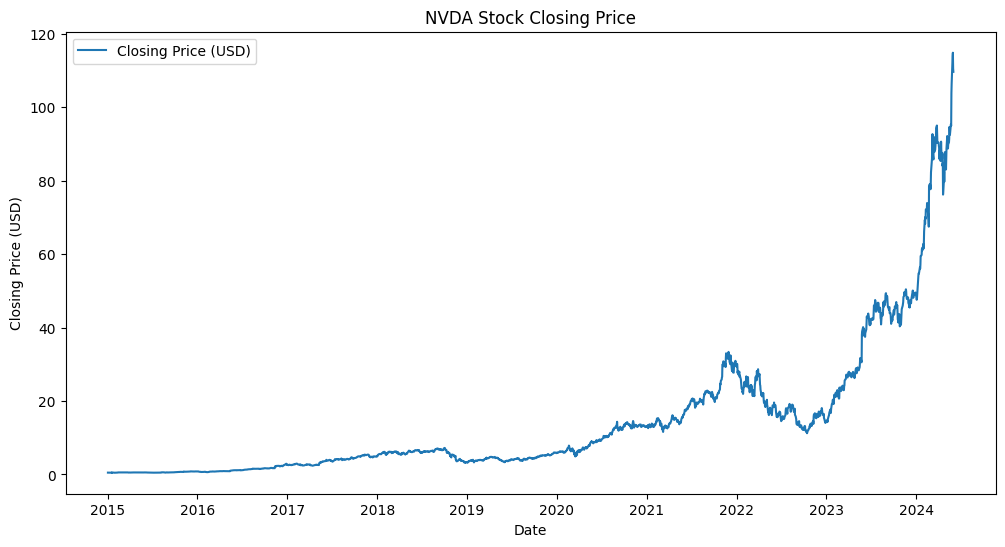

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download dataset
path = kagglehub.dataset_download("haiderrasoolqadri/nvidia-corporation-nvda-stock-2015-2024")
print("Path to dataset files:", path)

# Load dataset
dataframe = pd.read_csv(path + "/nvidia_stock_2015_to_2024.csv")

# Preprocess dataset
dataframe.drop(columns=['Unnamed: 0'], inplace=True)
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe.set_index('date', inplace=True)
dataframe = dataframe.asfreq('B')

# Check for duplicate data
if dataframe.duplicated().sum() > 0:
    print("Duplicate data found. Removing duplicates...")
    dataframe.drop_duplicates(inplace=True)

# Check for NaN data
close_prices = dataframe['close'].copy()
close_prices = close_prices.replace([np.inf, -np.inf], np.nan)
close_prices = close_prices.dropna()

# DATA VISUALIZATION -------------
# plot stock closing prices

plt.figure(figsize=(12, 6))
plt.plot(dataframe['close'], label = 'Closing Price (USD)')
plt.title('NVDA Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()


In [7]:
# check for stationary using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(close_prices)
print("ADF statistic: ", result[0])
print("p-value: ", result[1])
print("reject null hypothesis since p<0.05, meaning data is not stationary")
print()

#thus we must do differencing to make data stationary
df_diff = dataframe['close'].diff().dropna()

print("Rerun after differencing")
#rerun ADF test
result2 = adfuller(df_diff)
print("ADF statistic: ", result2[0])
print("p-value: ", result2[1])
print("p<0.0.5 thus data is now stationary!")

ADF statistic:  5.114040028348363
p-value:  1.0
reject null hypothesis since p<0.05, meaning data is not stationary

Rerun after differencing
ADF statistic:  -6.801874107955184
p-value:  2.226432563922902e-09
p<0.0.5 thus data is now stationary!


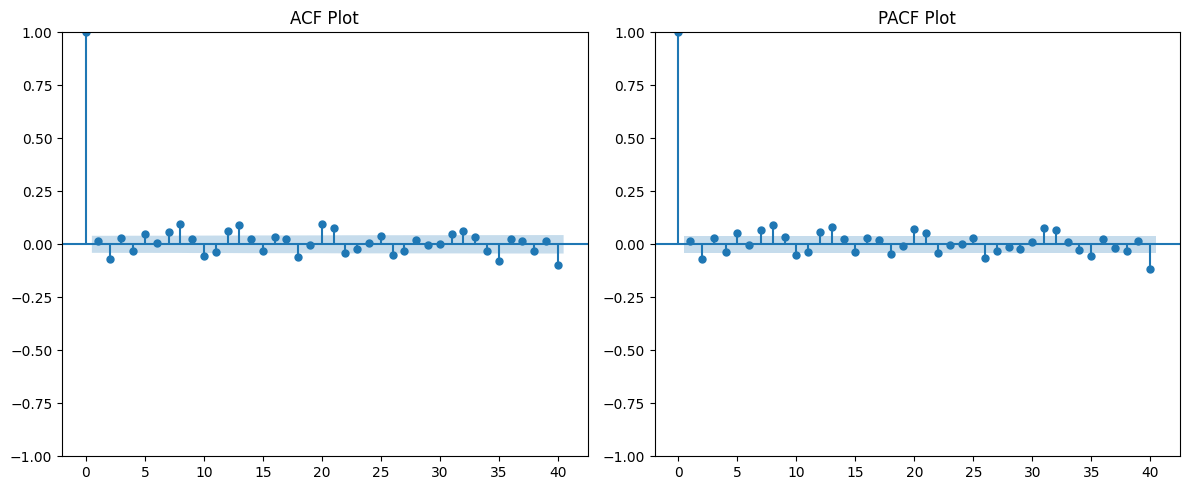

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 5))

# ACF on differenced data (Autocorrelation Function)
# used to find q value (AutoRegressive AR(q))
plt.subplot(1, 2, 1) # to show plots for ACF and PACF side by side
plot_acf(df_diff, lags=40, ax=plt.gca())
plt.title("ACF Plot")


# PACF on differenced data (Partial Autocorrelation Function)
# used to find p value (Moving Average MA(p))
plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=40, ax=plt.gca()) #ax ensure plots are in correct space
plt.title("PACF Plot")

plt.tight_layout() # ensures no overlaps between plots
plt.show()


In [13]:
from statsmodels.tsa.arima.model import ARIMA
close_prices = close_prices.asfreq('B')

model = ARIMA(dataframe['close'], order=(2, 2, 3)) # using p=2 d=2 and q=3 from auto_arima
model_fit = model.fit()
print(model_fit.summary())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2370
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -2640.262
Date:                Sun, 01 Jun 2025   AIC                           5292.525
Time:                        12:05:54   BIC                           5327.144
Sample:                             0   HQIC                          5305.128
                               - 2370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2514      0.081     -3.086      0.002      -0.411      -0.092
ar.L2          0.2674      0.082      3.262      0.001       0.107       0.428
ma.L1         -0.7419      0.079     -9.412      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


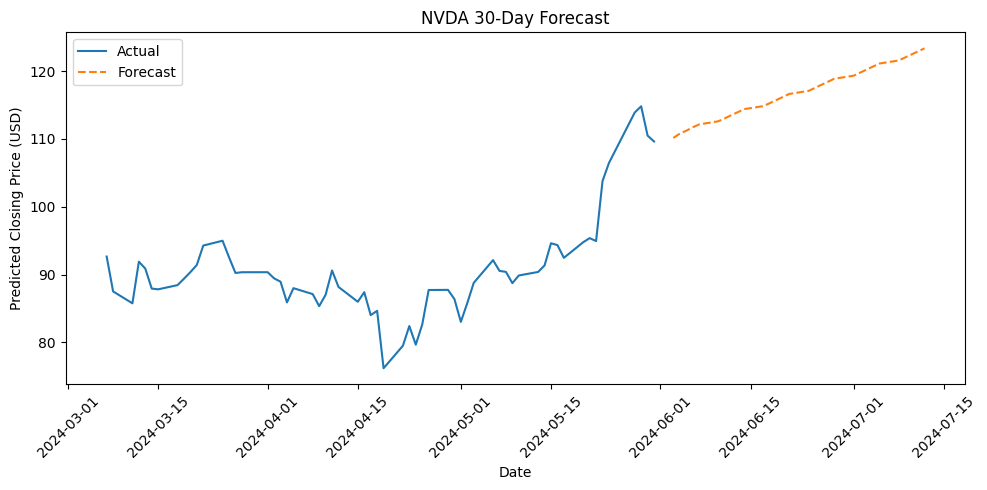

In [12]:
n_steps = 30 # number of days to forecast
forecast = model_fit.forecast(steps = n_steps)
forecast_result = forecast

# forecast_result.to_csv("forecast_result.csv")


# plot forecast for visualizations
from datetime import timedelta

# Create the forecast DataFrame
forecast_df = forecast.to_frame(name="Forecast")

# Set real dates as index
close_prices.index = pd.to_datetime(close_prices.index)

last_date = close_prices.index[-1]  # must be a datetime index
forecast_df.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')  # 'B' = business days


plt.figure(figsize=(10, 5))
plt.plot(close_prices[-60:], label='Actual')  # last 60 days of actuals
plt.plot(forecast_df, label='Forecast', linestyle='--')
plt.title("NVDA 30-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Predicted Closing Price (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()